# LSTM Time Series Forecasting for NVIDIA Stock Prices

## Data Extraction

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime

import yfinance as yf

In [34]:
# Define the stock list
stocks_list = ['NVDA']

# Define the date range
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

# Download stock data
for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

# Reset the index and rename columns
NVDA.reset_index(inplace=True)
NVDA.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Check for NaN values in each column
print("\nNumber of NaN values in each column:")
print(NVDA.isna().sum())

[*********************100%%**********************]  1 of 1 completed


Number of NaN values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [35]:
# Create a new data frame with only the 'Close' column
nvidia_data = NVDA[['Close']]

# Drop rows where 'Close' is NaN
nvidia_data = nvidia_data.dropna()

# Convert the DataFrame to a NumPy array
data = nvidia_data.values

## Data Pre-Processing

In [36]:
# Standardize the data (standardization is less sensitive to outliers compared to normalization)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
# Split the scaled data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train, y_train datasets
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i,0])

# Convert the x_train and y_train to numppy array and reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(341, 60, 1)

## Long Short-Term Memory (LSTM)

In [38]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=25))
model.add(Dense(units=1))
model.summary()

/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Compile and train the LSTM model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0578
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0163
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0126
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0105
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0084
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0093
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0070
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086
Epoch 9/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086
Epoch 10/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0079
Epoch 11/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0047
Epoch 12/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0076
Epoch 13/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0038
Epoch 14/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0037
Epoch 15/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s

In [40]:
# Prepare test data and make predictions
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = data[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i -60:i, 0])

In [41]:
# Convert the data to a numpy array and reshape the data
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [42]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print(f"Prediction Horizon: 1")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Prediction Horizon: 1


In [43]:
# Evaluate model performance using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 5.246444110316759


/var/folders/8h/4l9_c_8x4pq675w1qcpf84hw0000gn/T/ipykernel_25756/250737844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


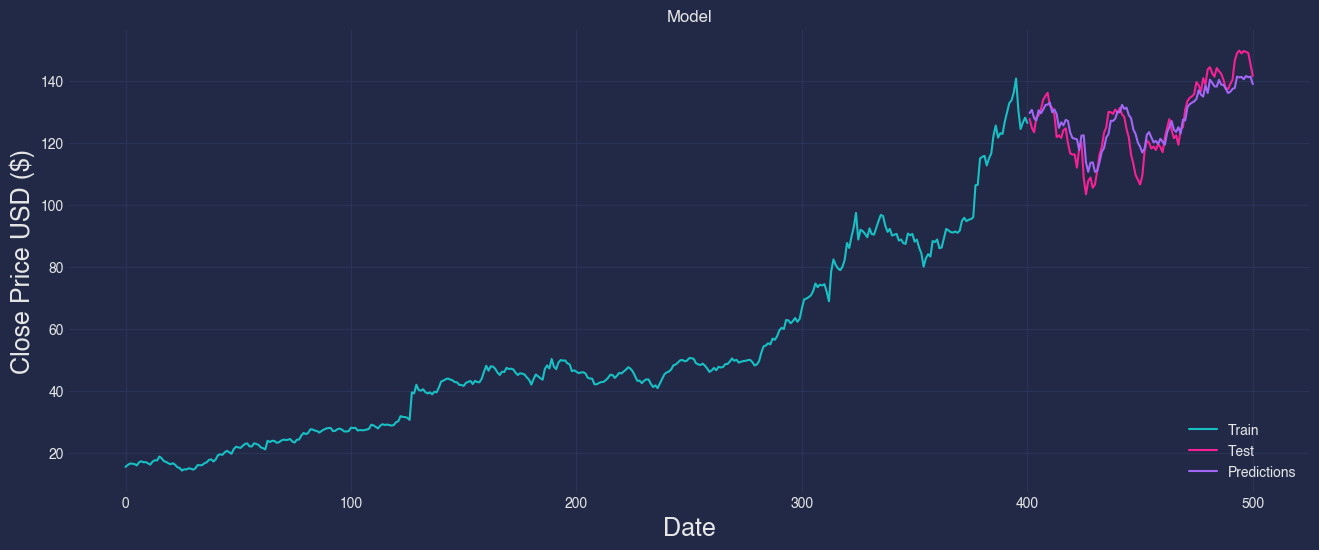

In [44]:
# Plot the predicted stock prices against actual prices
dataset = nvidia_data.filter(['Close'])
train = dataset[:training_data_len]
test = dataset[training_data_len:]
test['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [45]:
# Show the test and predicted price
test

,Close,Predictions
401,127.709999,129.625656
402,124.839996,130.643524
403,123.410004,127.910233
404,128.279999,127.241470
405,128.850006,130.508881
...,...,...
496,149.649994,140.530182
497,149.330002,141.569641
498,149.000000,141.179962
499,145.240005,141.323380


Text(0, 0.5, 'Actual Values')

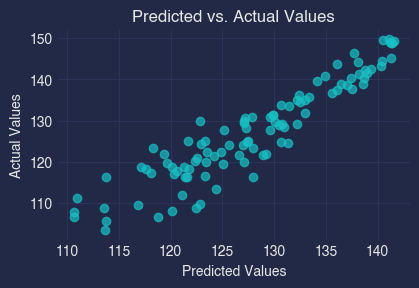

In [46]:
# Evaluate how well the LSTM model performs.
# If the predictions perfectly match the actual values, the points should align along a straight line with a slope of 1.

actual_values = y_test
predicted_values = predictions

plt.figure(figsize=(10, 6))

# Scatter plot of predicted vs. actual values
plt.subplot(2, 2, 1)
plt.scatter(predicted_values, actual_values, alpha=0.7)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

Text(0, 0.5, 'Residuals')

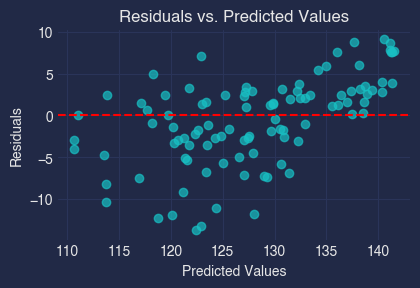

In [47]:
# Evaluate the relationship between observed and predicted values.
# Residuals distributed randomly around y = 0 indicate a well-captured data structure, whereas patterns or trends indicate model inadequacy.

# Calculate residuals
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))

# Residuals vs. Predicted Values
plt.subplot(2, 2, 2)
plt.scatter(predicted_values, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Frequency')

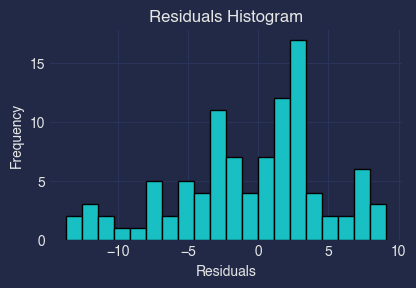

In [48]:
plt.figure(figsize=(10, 6))

# Residuals Histogram
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

## Improving LSTM

In [49]:
# Helper function to plot predictions vs actual prices
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.plot(actual, label='Actual Prices')
    plt.plot(predicted, label='Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.legend()
    plt.show()

# Helper function to calculate RMSE
def calculate_rmse(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse

### Experimental Model 1: Increased LSTM layers

Epoch 1/20


/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0887
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0199
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0122
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0247
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0191
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0131
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0075
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0106
Epoch 9/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0104
Epoch 10/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0090
Epoch 11/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0080
Epoch 12/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0100
Epoch 13/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0079
Epoch 14/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0072
Epoch 15/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step 

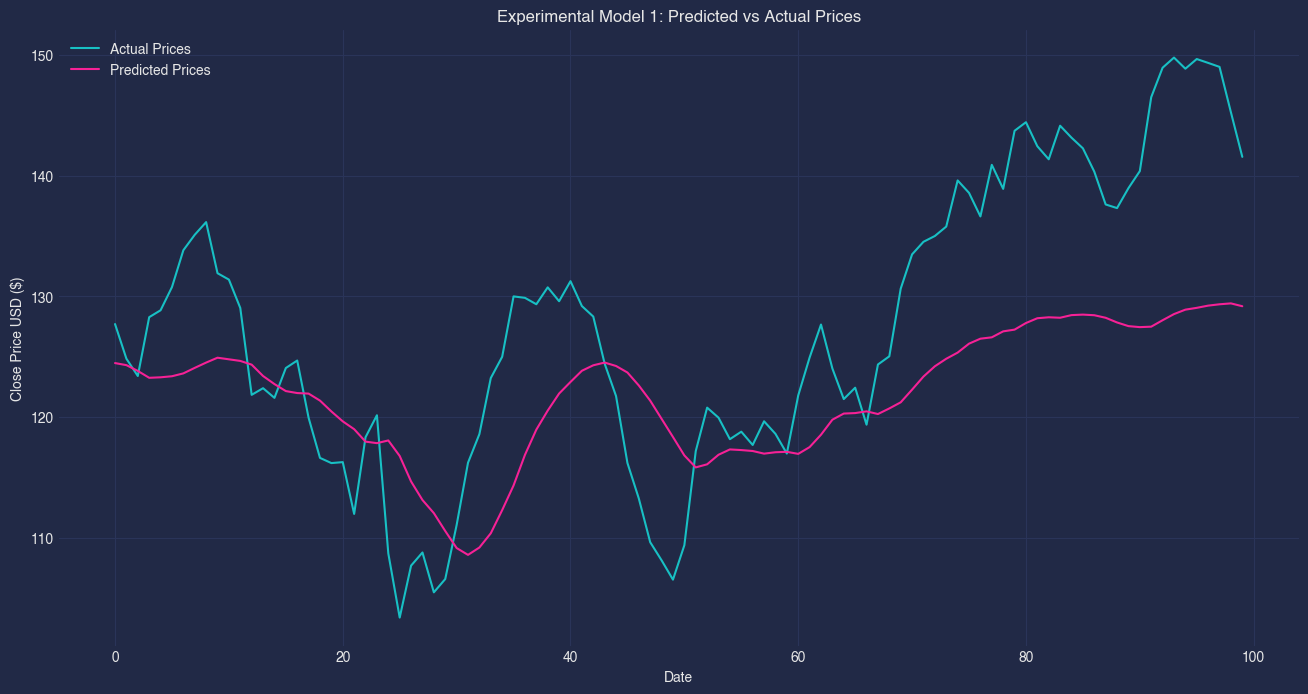

In [50]:
# Experimental Model 1
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(LSTM(units=25, return_sequences=True))
model1.add(LSTM(units=25))
model1.add(Dense(units=1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

# Predicting and calculating RMSE for Model 1
predictions1 = model1.predict(x_test)
predictions1 = scaler.inverse_transform(predictions1)
rmse1 = calculate_rmse(y_test, predictions1)
print(f'RMSE for Experimental Model 1: {rmse1}')
plot_predictions(y_test, predictions1, 'Experimental Model 1: Predicted vs Actual Prices')

### Experimental Model 2: Increased units per layer

Epoch 1/20


/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0695
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0114
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0139
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0126
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0083
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0095
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0090
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0065
Epoch 9/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0064
Epoch 10/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0073
Epoch 11/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0044
Epoch 12/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0069
Epoch 13/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0038
Epoch 14/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0057
Epoch 15/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step 

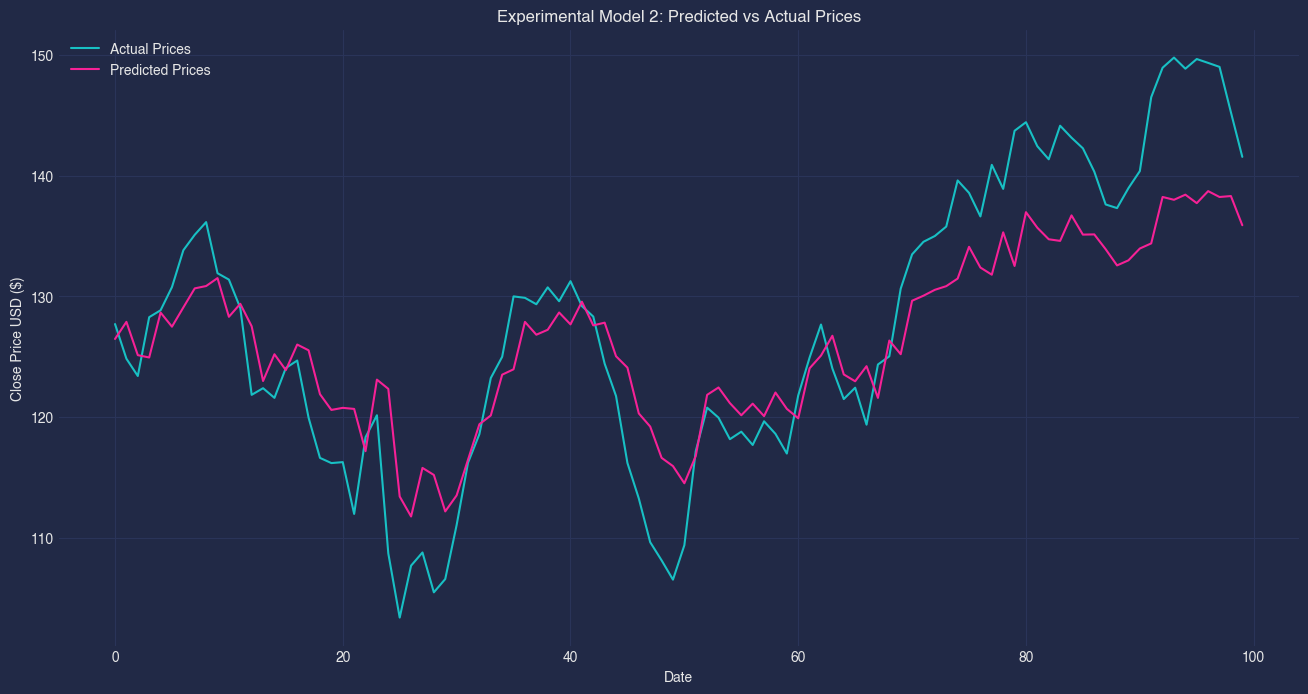

In [51]:
# Experimental Model 2
model2 = Sequential()
model2.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(LSTM(units=50, return_sequences=True))
model2.add(LSTM(units=50))
model2.add(Dense(units=1))

model2.compile(optimizer='adam', loss='mean_squared_error')
model2.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

# Predicting and calculating RMSE for Model 2
predictions2 = model2.predict(x_test)
predictions2 = scaler.inverse_transform(predictions2)
rmse2 = calculate_rmse(y_test, predictions2)
print(f'RMSE for Experimental Model 2: {rmse2}')
plot_predictions(y_test, predictions2, 'Experimental Model 2: Predicted vs Actual Prices')

### Experimental Model 3: Added dropout layers

Epoch 1/20


/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1029
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0223
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0135
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0139
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0097
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0100
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0115
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0142
Epoch 9/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0117
Epoch 10/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0102
Epoch 11/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0098
Epoch 12/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0095
Epoch 13/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0091
Epoch 14/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0060
Epoch 15/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step 

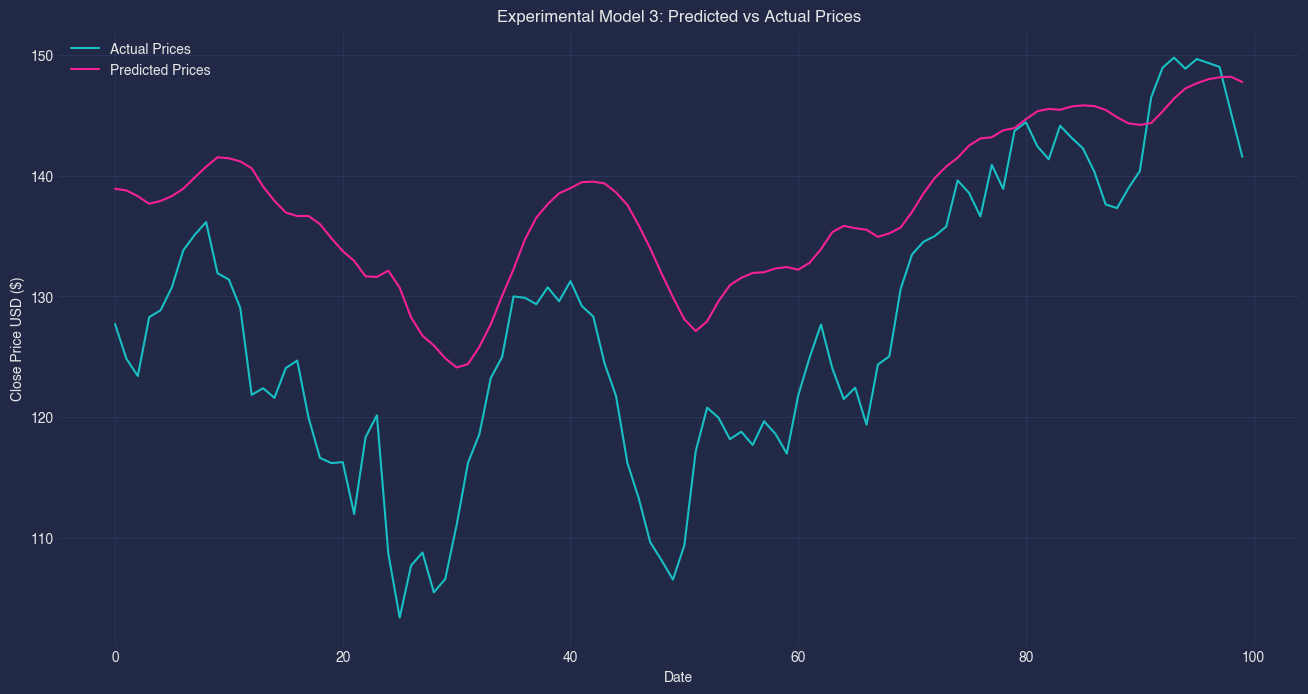

In [52]:
# Experimental Model 3
model3 = Sequential()
model3.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=25))
model3.add(Dense(units=1))

model3.compile(optimizer='adam', loss='mean_squared_error')
model3.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

# Predicting and calculating RMSE
predictions3 = model3.predict(x_test)
predictions3 = scaler.inverse_transform(predictions3)
rmse3 = calculate_rmse(y_test, predictions3)
print(f'RMSE for Experimental Model 3: {rmse3}')
plot_predictions(y_test, predictions3, 'Experimental Model 3: Predicted vs Actual Prices')

### Experimental Model 4: Changed the optimizer

/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0481
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0159
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0148
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0121
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0100
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0102
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0091
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0074
Epoch 9/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0086
Epoch 10/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0071
Epoch 11/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0064
Epoch 12/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0061
Epoch 13/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0051
Epoch 14/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0052
Epoch 15/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s

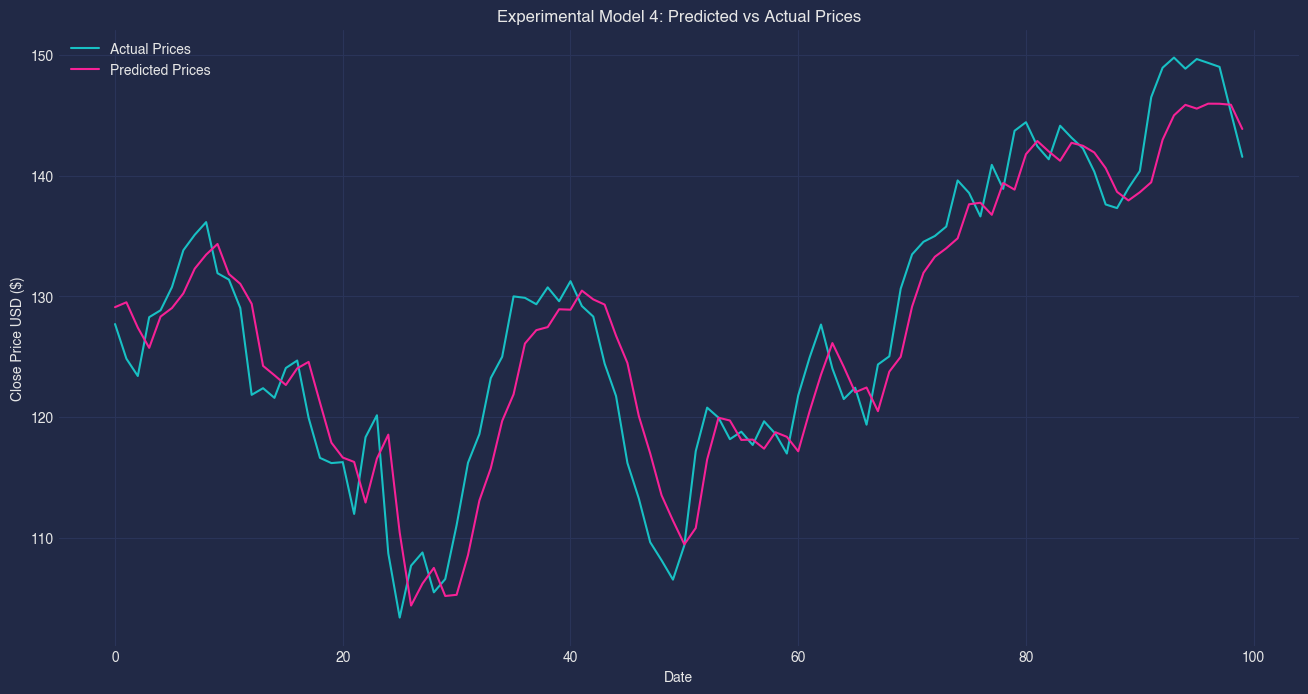

In [53]:
# Experimental Model 4
model4 = Sequential()
model4.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model4.add(LSTM(units=50, return_sequences=True))
model4.add(LSTM(units=25))
model4.add(Dense(units=1))
model4.summary()

model4.compile(optimizer='rmsprop', loss='mean_squared_error')
model4.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

# Predicting and calculating RMSE
predictions4 = model4.predict(x_test)
predictions4 = scaler.inverse_transform(predictions4)
rmse4 = calculate_rmse(y_test, predictions4)
print(f'RMSE for Experimental Model 4: {rmse4}')
plot_predictions(y_test, predictions4, 'Experimental Model 4: Predicted vs Actual Prices')

### Experimental Model 5: Increased batch size and disabled shuffle

/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2636
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1245
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1047
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1805
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1363
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1123
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0917
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0810
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0741
Epoch 10/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0677
Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0650
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0552
Epoch 13/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0532
Epoch 14/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0403
Epoch 15/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0347
Epoc

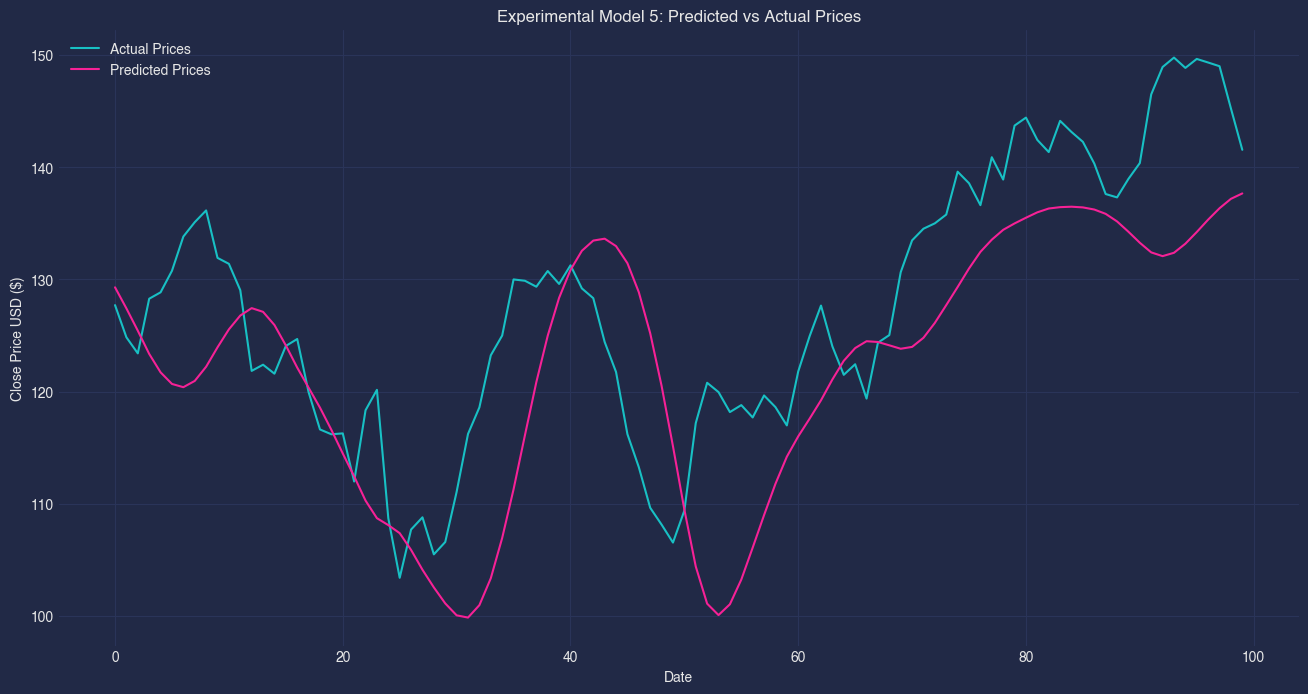

In [54]:
# Experimental Model 5
model5 = Sequential()
model5.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model5.add(LSTM(units=50, return_sequences=True))
model5.add(LSTM(units=25))
model5.add(Dense(units=1))
model5.summary()

model5.compile(optimizer='adam', loss='mean_squared_error')
model5.fit(x_train, y_train, batch_size=5, epochs=20, shuffle=False)

# Predicting and calculating RMSE
predictions5 = model5.predict(x_test)
predictions5 = scaler.inverse_transform(predictions5)
rmse5 = calculate_rmse(y_test, predictions5)
print(f'RMSE for Experimental Model 5: {rmse5}')
plot_predictions(y_test, predictions5, 'Experimental Model 5: Predicted vs Actual Prices')

### Experimental Model 6: Changed the prediction horizon to 50

[*********************100%%**********************]  1 of 1 completed


Number of NaN values in each column:
Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64



/Users/bernicelau/.pyenv/versions/anaconda3-2023.03/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1383
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1029
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0858
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0806
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1050
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0728
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0724
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0471
Epoch 9/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0397
Epoch 10/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0500
Epoch 11/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0590
Epoch 12/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0446
Epoch 13/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0275
Epoch 14/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0297
Epoch 15/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 3s

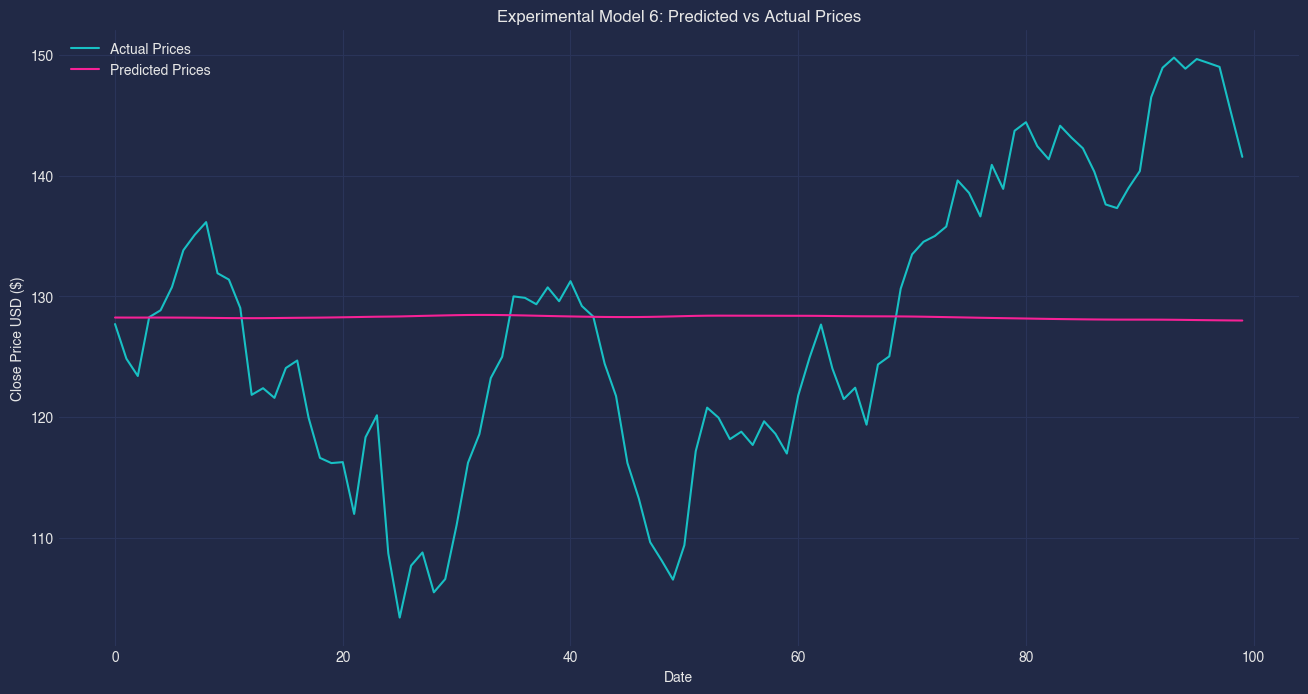

In [58]:
# Extract the dataset
stocks_list = ['NVDA']
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in stocks_list:
    globals()[stock] = yf.download(stock, start, end)

# Clean up and format the dataset
NVDA.reset_index(inplace=True)
NVDA.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

print("\nNumber of NaN values in each column:")
print(NVDA.isna().sum())

nvidia_data = NVDA[['Close']]
nvidia_data = nvidia_data.dropna()

data = nvidia_data.values
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Split the scaled data into training and testing sets
training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:int(training_data_len), :]

# Change Prediction Horizon to 50
x_train, y_train = [], []
for i in range(60, len(train_data) - 50):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i + 50, 0])

# Convert the x_train and y_train to numpy array and reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

# Experimental Model 6
model6 = Sequential()
model6.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model6.add(LSTM(units=50, return_sequences=True))
model6.add(LSTM(units=25))
model6.add(Dense(units=1))
model6.summary()

model6.compile(optimizer='adam', loss='mean_squared_error')
model6.fit(x_train, y_train, batch_size=1, epochs=20, shuffle=True)

# Predicting and calculating RMSE
predictions6 = model6.predict(x_test)
predictions6 = scaler.inverse_transform(predictions6)
rmse6 = calculate_rmse(y_test, predictions6)
print(f'RMSE for Experimental Model 6: {rmse6}')
plot_predictions(y_test, predictions6, 'Experimental Model 6: Predicted vs Actual Prices')